# **Multi-class Classification**

## 1. Creating a toy multi-class dataset

In [3]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [4]:
# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

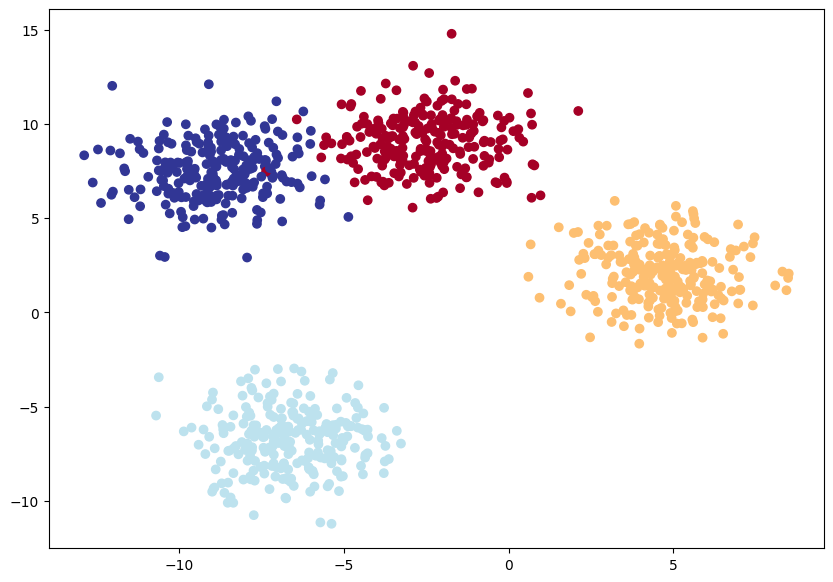

In [5]:
# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)
# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c = y_blob, cmap=plt.cm.RdYlBu)

In [6]:
# Calculate accuracy - out or 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

In [7]:
import requests
from pathlib import Path

# Download helper functions
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Download helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)


from helper_functions import plot_predictions, plot_decision_boundary

Download helper_functions.py


## 2. Building a multi-class classification model in PyTorch

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [9]:
 # Build a multi-class classification model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """
    Initializes multi-class classification model.

    Args:
      input_features (int): Number of input features to the model
      output_features (int): Number of outputs features (number of output classes)
      hidden_units (int): Number of hidden units between layers, default 8

    Returns:

    Example:
    """

    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )
  def forward(self, x):
    return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model = BlobModel(input_features=2,
                  output_features=4,
                  hidden_units=8).to(device)
model


BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [10]:
X_blob_train.shape, y_blob_train[:5]

(torch.Size([800, 2]), tensor([1, 0, 2, 2, 0]))

In [11]:
torch.unique(y_blob_train)

tensor([0, 1, 2, 3])

## 3. Create a loss function and an optimizer for a multi-class classification

In [12]:
# Create a loss function for multi-class classification
loss_fn = nn.CrossEntropyLoss()

# Create an optimizer for multi-class classification
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr = 0.1)

## 4. Getting prediction probabilities for a multi-class PyTorch model

In order to evaluate and train and test our model, we need to convert our model's outputs (logits) to prediction probabilities and then to prediction labels.

Logits (raw output of the model) -> Pred probs (use `torch.softmax`) -> Pred labels (take the argmax of the prediction probabilities)

In [13]:
# Let's get some raw outputs of out model (logits)
model.eval()
with torch.inference_mode():
  y_logits = model(X_blob_test.to(device))

y_logits[:10]


tensor([[ 0.1714, -0.0844,  0.3373,  0.1734],
        [-0.8466,  0.3329,  1.2078,  0.7138],
        [-0.3794, -0.2200,  0.4973,  0.0557],
        [ 0.1072, -0.1554,  0.3379,  0.0663],
        [ 0.0477,  0.3128,  0.8289,  0.7393],
        [-1.1433,  0.4137,  1.3912,  0.8289],
        [-0.1822, -0.2255,  0.4088,  0.0284],
        [ 0.0336,  0.2701,  0.8818,  0.7205],
        [-0.7466, -0.1483,  0.6451,  0.1651],
        [ 0.0415,  0.2769,  0.8528,  0.7134]])

In [14]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

In [15]:
# Convert out model's logit outputs to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])


tensor([[ 0.1714, -0.0844,  0.3373,  0.1734],
        [-0.8466,  0.3329,  1.2078,  0.7138],
        [-0.3794, -0.2200,  0.4973,  0.0557],
        [ 0.1072, -0.1554,  0.3379,  0.0663],
        [ 0.0477,  0.3128,  0.8289,  0.7393]])
tensor([[0.2527, 0.1957, 0.2983, 0.2532],
        [0.0595, 0.1934, 0.4640, 0.2831],
        [0.1634, 0.1916, 0.3926, 0.2524],
        [0.2507, 0.1928, 0.3158, 0.2407],
        [0.1542, 0.2010, 0.3368, 0.3080]])


In [16]:
# Convert our model's prediction probabilities to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])

In [17]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

## 5. Creating  a training loop and testing loop for a multi-class PyTorch model

In [18]:
# Fit the multi-class model to the data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
  ### Training
  model.train()

  y_logits = model(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_blob_train.type(torch.LongTensor))
  acc = accuracy_fn(y_true=y_blob_train,
                 y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()


  ### Testing
  model.eval()
  with torch.inference_mode():
    test_logits = model(X_blob_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test,
                           y_pred=test_preds)

    if epoch % 10 == 0:
      print(f"Epcoh: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test loss: {test_loss: .4f}, Test_acc: {test_acc: .2f}%")

Epcoh: 0 | Loss: 1.4530, Acc: 24.62% | Test loss:  1.1315, Test_acc:  68.00%
Epcoh: 10 | Loss: 0.6106, Acc: 73.12% | Test loss:  0.5139, Test_acc:  79.00%
Epcoh: 20 | Loss: 0.4531, Acc: 74.00% | Test loss:  0.3705, Test_acc:  81.00%
Epcoh: 30 | Loss: 0.3743, Acc: 92.62% | Test loss:  0.3007, Test_acc:  92.00%
Epcoh: 40 | Loss: 0.3191, Acc: 95.38% | Test loss:  0.2535, Test_acc:  97.00%
Epcoh: 50 | Loss: 0.2764, Acc: 97.00% | Test loss:  0.2178, Test_acc:  98.50%
Epcoh: 60 | Loss: 0.2416, Acc: 97.88% | Test loss:  0.1892, Test_acc:  99.00%
Epcoh: 70 | Loss: 0.2113, Acc: 98.50% | Test loss:  0.1646, Test_acc:  99.00%
Epcoh: 80 | Loss: 0.1841, Acc: 98.75% | Test loss:  0.1428, Test_acc:  99.00%
Epcoh: 90 | Loss: 0.1598, Acc: 99.00% | Test loss:  0.1231, Test_acc:  99.00%


### 6. Making and evaluating predictions with a PyTorch multi-class model

In [19]:
model.eval()
with torch.inference_mode():
  y_logits = model(X_blob_test)

y_logits[:10]

tensor([[ 1.3753,  2.5051, -1.7384, -0.3115],
        [ 0.1920, -0.7645, -0.6543,  6.1616],
        [-7.2738, -4.0859,  6.9178,  0.8485],
        [-0.0738,  1.4584, -0.3589, -0.4136],
        [ 7.6274,  3.8367, -5.4762,  1.3665],
        [-0.4402, -1.4940, -0.2864,  7.5963],
        [-5.8116, -2.9668,  5.4920,  0.4333],
        [ 7.5066,  3.4410, -5.2316,  1.7523],
        [-9.9824, -6.2063,  9.3169,  2.3045],
        [ 7.4068,  3.5396, -5.2262,  1.5773]])

In [20]:
# Go from logits to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[2.3123e-01, 7.1569e-01, 1.0276e-02, 4.2802e-02],
        [2.5435e-03, 9.7729e-04, 1.0912e-03, 9.9539e-01],
        [6.8497e-07, 1.6601e-05, 9.9768e-01, 2.3075e-03],
        [1.4100e-01, 6.5259e-01, 1.0602e-01, 1.0038e-01],
        [9.7609e-01, 2.2040e-02, 1.9891e-06, 1.8639e-03],
        [3.2320e-04, 1.1267e-04, 3.7693e-04, 9.9919e-01],
        [1.2248e-05, 2.1064e-04, 9.9346e-01, 6.3127e-03],
        [9.8008e-01, 1.6811e-02, 2.8782e-06, 3.1059e-03],
        [4.1499e-09, 1.8111e-07, 9.9910e-01, 8.9980e-04],
        [9.7670e-01, 2.0429e-02, 3.1866e-06, 2.8711e-03]])

In [21]:
# Go from pred probs to pred labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

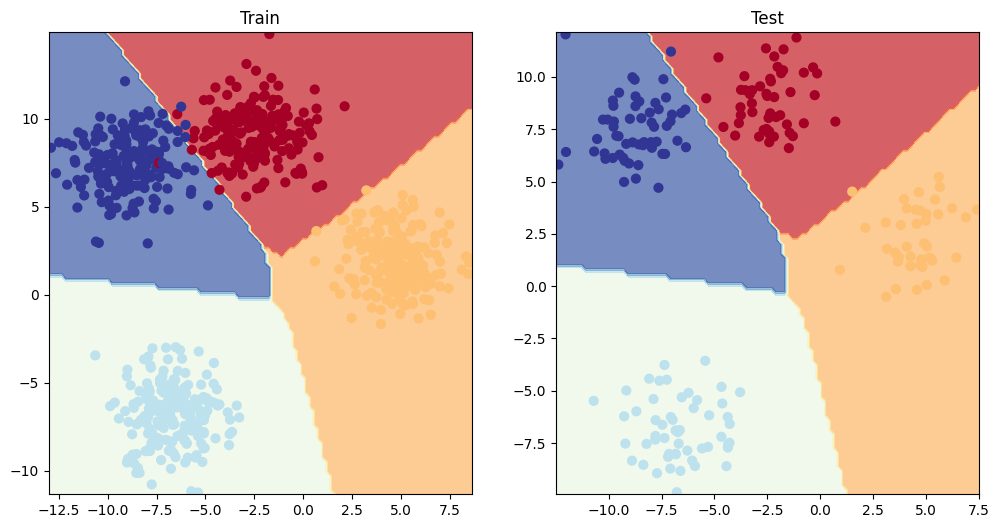

In [22]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_blob_test, y_blob_test)

## Few more classification metrics (to evaluate classification model)

* Accuracy - out of 100 samples, how many does our model get right?
* Precision
* Recall
* F1-score
* Confusion matrix
* Classification report

In [23]:
!pip install torchmetrics

In [29]:
from torchmetrics import Accuracy

torchmetric_accuracy = Accuracy(task="multiclass", num_classes=NUM_CLASSES).to(device)

# calculate accuracy
torchmetric_accuracy(y_preds, y_blob_test)

tensor(0.9900)